# Fix pathing

In [1]:
import sys


sys.path.append("..")


In [2]:
import constants

import os


constants.PROJECT_DIRECTORY_PATH = os.path.dirname(os.path.dirname(constants.PROJECT_DIRECTORY_PATH))


# Imports

In [3]:
import datahandler
import plotter
import utils

import matplotlib.pyplot as plt
import matplotlib.pyplot
import matplotlib.dates
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.patches as mpatches
import scipy.stats


# Constants

In [4]:
data_preprocessor = datahandler.DataPreprocessorOUS_V2()
data_preprocessor.execute()

data_loader = datahandler.DataLoader(datahandler.DataPreprocessorOUS_V2)
data_loader.execute(clean=False, processed=False, enhanced=True)


Loading dataset: 100%|██████████| 2/2 [00:02<00:00,  1.39s/it]


# Methods


In [5]:
def add_info(dataframe: pd.DataFrame) -> pd.DataFrame:
    historic_steps = {
        "duration_incident_creation": ("time_call_received", "time_incident_created"),
        "duration_resource_appointment": ("time_incident_created", "time_resource_appointed"),
        "duration_resource_preparing_departure": ("time_resource_appointed", "time_ambulance_dispatch_to_scene"),
        "duration_dispatching_to_scene": ("time_ambulance_dispatch_to_scene", "time_ambulance_arrived_at_scene"),
        "duration_at_scene": ("time_ambulance_arrived_at_scene", "time_ambulance_dispatch_to_hospital", "time_ambulance_available"),
        "duration_dispatching_to_hospital": ("time_ambulance_dispatch_to_hospital", "time_ambulance_arrived_at_hospital"),
        "duration_at_hospital": ("time_ambulance_arrived_at_hospital", "time_ambulance_available")
    }

    for step, times in historic_steps.items():
        if len(times) == 3:
            dataframe.loc[dataframe[times[1]].isna(), step] = (dataframe[times[2]] - dataframe[times[0]]).dt.total_seconds()
            dataframe.loc[~dataframe[times[1]].isna(), step] = (dataframe[times[1]] - dataframe[times[0]]).dt.total_seconds()
        else:
            dataframe[step] = (dataframe[times[1]] - dataframe[times[0]]).dt.total_seconds()
    
    response_time_cols = [
        'duration_incident_creation',
        'duration_resource_appointment',
        'duration_resource_preparing_departure',
        'duration_dispatching_to_scene'
    ]
    dataframe['total_response_time'] = dataframe[response_time_cols].sum(axis=1)

    dataframe["complied"] = np.nan
    # Define the criteria for response times
    criteria = {
        ('A', True): 12 * 60,
        ('A', False): 25 * 60,
        ('H', True): 30 * 60,
        ('H', False): 40 * 60
    }

    for (triage, urban), group in dataframe.groupby(['triage_impression_during_call', 'urban_settlement_ssb']):
        limit = criteria.get((triage, urban))
        if limit is not None:
            dataframe.loc[group.index, 'complied'] = group['total_response_time'] < limit

    return dataframe


In [6]:
def plot_compliance_rate(dataframe: pd.DataFrame, urban: bool = True, limit_left: str = None, limit_right: str = None, degree=3):
    """Plot the compliance rate from call data filtered by urban area status with a polynomial trend line and show row count."""
    def day_of_year_to_date(day_of_year, year=2019):
        """Convert day of year to date format 'Month Day'."""
        day_of_year = int(day_of_year)
        date = datetime(year, 1, 1) + timedelta(days=day_of_year - 1)
        return date.strftime('%B %d')

    def first_day_of_each_month(year=2019):
        """Generate first day of each month positions for the given year."""
        month_starts = []
        month_labels = []
        for month in range(1, 13):
            first_day = datetime(year, month, 1)
            month_starts.append(first_day.timetuple().tm_yday)
            month_labels.append(first_day.strftime('%B'))
        return month_starts, month_labels

    # extract date from time_call_received
    dataframe["day_of_year"] = dataframe["time_call_received"].dt.day_of_year

    start_time = pd.to_datetime('07:00:00').time()
    end_time = pd.to_datetime('18:59:59').time()

    # filter rows where time is within the defined bounds
    dataframe = dataframe[dataframe['time_call_received'].dt.time.between(start_time, end_time)]

    # filter data by urban settlement and compute compliance rate
    if urban is not None:
        dataframe = dataframe[dataframe["urban_settlement_ssb"] == urban]
    compliance_rate = dataframe.groupby("day_of_year")["complied"].mean().dropna() * 100
    count_data = dataframe.groupby("day_of_year").size() / 3

    x = compliance_rate.index.astype(float)
    y = compliance_rate.values.astype(float)
    mean_compliance_rate = compliance_rate.mean()

    # identify best and worst compliance days
    worst_day = compliance_rate.idxmin()
    best_day = compliance_rate.idxmax()
    average_day = (compliance_rate - mean_compliance_rate).abs().idxmin()

    best_day_date = day_of_year_to_date(best_day)
    worst_day_date = day_of_year_to_date(worst_day)
    average_day_date = day_of_year_to_date(average_day)

    # plot compliance rate
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(x, y, label="Compliance Rate")
    z = np.polyfit(x, y, degree)
    p = np.poly1d(z)
    ax1.plot(x, p(x), "-", color='grey', label=f"{degree} Degree Polynomial Fit")

    ax2 = ax1.twinx()
    ax2.fill_between(count_data.index.astype(float), 0, count_data.values, color="darkgrey", alpha=0.5)
    ax2.set_ylim(0, 600)
    ax2.set_ylabel("Total Events")

    # Adjust x-axis to show month names
    month_starts, month_labels = first_day_of_each_month()
    ax1.set_xticks(month_starts)
    ax1.set_xticklabels(month_labels)
    ax1.tick_params(axis='x', labelrotation=30)
    ax1.set_xlim((0, 365))

    ax1.axvline(x=best_day, color='green', linestyle=':', label=f"Best Day ({best_day_date}): {compliance_rate[best_day]:.2f}%")
    ax1.axvline(x=worst_day, color='red', linestyle=':', label=f"Worst Day ({worst_day_date}): {compliance_rate[worst_day]:.2f}%")
    ax1.axvline(x=average_day, color='blue', linestyle=':', label=f"Average Day ({average_day_date}): {compliance_rate[average_day]:.2f}%")

    ax1.set_ylim((0, 101))

    # set x-axis limits if specified
    if limit_left:
        ax1.set_xlim(left=pd.Timestamp(limit_left))
    if limit_right:
        ax1.set_xlim(right=pd.Timestamp(limit_right))

    ax1.xaxis.grid(False)
    title = f"Compliance Rate for{' Urban' if urban else ' Non-Urban' if urban is not None else ''} Historical Incidents During Day Shift"
    plt.title(title, fontdict=constants.FONT_PROPERTIES_SUB_HEADER)
    ax1.set_ylabel("Compliance Rate (%)")

    # Create and place the legend
    lines, labels = ax1.get_legend_handles_labels()
    patches = [mpatches.Patch(color='darkgrey', alpha=0.5, label='Total Events')]
    ax1.legend(
        lines + patches, labels + ['Total Events'],
        loc='center right'
    )

    plt.savefig(os.path.join(constants.PROJECT_DIRECTORY_PATH, "source", "analysis", "plots", title + ".png"), dpi=300, bbox_inches='tight')

    plt.show()


In [7]:
def plot_total_incidents_per_day(dataframe: pd.DataFrame, urban: bool = True, limit_left: str = None, limit_right: str = None, degree=3):
    """Plot total incidents per day from call data filtered by urban area status with a polynomial trend line."""
    def day_of_year_to_date(day_of_year, year=2019):
        """Convert day of year to date format 'Month Day'."""
        day_of_year = int(day_of_year)
        date = datetime(year, 1, 1) + timedelta(days=day_of_year - 1)
        return date.strftime('%B %d')

    def first_day_of_each_month(year=2019):
        """Generate first day of each month positions for the given year."""
        month_starts = []
        month_labels = []
        for month in range(1, 13):
            first_day = datetime(year, month, 1)
            month_starts.append(first_day.timetuple().tm_yday)
            month_labels.append(first_day.strftime('%B'))
        return month_starts, month_labels

    # extract date from time_call_received
    dataframe["day_of_year"] = dataframe["time_call_received"].dt.day_of_year

    # group data by day of the year and sum across each group to account for multiple rows per day
    grouped_data = dataframe.groupby("day_of_year").agg({f"total_{incident_type}_incidents_hour_{hour}": 'first' for incident_type in ['A', 'H', 'V1'] for hour in range(7, 19)})

    # Sum total incidents across the specified hours for each day
    grouped_data["total_incidents"] = grouped_data.sum(axis=1)
    
    # Now working with summed data
    total_incidents_per_day = grouped_data["total_incidents"]
    x = total_incidents_per_day.index.astype(float)
    y = total_incidents_per_day.values.astype(float)
    mean_total_incidents = total_incidents_per_day.mean()

    if urban is not None:
        dataframe = dataframe[dataframe["urban_settlement_ssb"] == urban]

    # filter rows where time is within the defined bounds
    start_time = pd.to_datetime('07:00:00').time()
    end_time = pd.to_datetime('19:00:00').time()

    dataframe = dataframe[dataframe['time_call_received'].dt.time.between(start_time, end_time)]
    compliance_rate = dataframe.groupby("day_of_year")["complied"].mean().dropna() * 100

    # identify best and worst days based on incidents
    worst_day = total_incidents_per_day.idxmax()
    best_day = total_incidents_per_day.idxmin()
    average_day = (total_incidents_per_day - mean_total_incidents).abs().idxmin()

    best_day_date = day_of_year_to_date(best_day)
    worst_day_date = day_of_year_to_date(worst_day)
    average_day_date = day_of_year_to_date(average_day)

    # pearson correlation
    combined_data = pd.DataFrame({
        'total_incidents': total_incidents_per_day,
        'compliance_rate': compliance_rate
    }).dropna()
    correlation, _ = scipy.stats.pearsonr(combined_data['total_incidents'], combined_data['compliance_rate'])
    print(f'Pearson Correlation: {correlation:.2f}')

    # plot total incidents
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(x, y, label="Total Incidents")
    z = np.polyfit(x, y, degree)
    p = np.poly1d(z)
    ax1.plot(x, p(x), "-", color='grey', label=f"{degree} Degree Polynomial Fit")

    # Adjust x-axis to show month names
    month_starts, month_labels = first_day_of_each_month()
    ax1.set_xticks(month_starts)
    ax1.set_xticklabels(month_labels)
    ax1.tick_params(axis='x', labelrotation=30)
    ax1.set_xlim((0, 365))

    ax1.axvline(x=best_day, color='green', linestyle=':', label=f"Least Active Day ({best_day_date}): {compliance_rate[best_day]:.2f}% Compliance")
    ax1.axvline(x=worst_day, color='red', linestyle=':', label=f"Most Active Day ({worst_day_date}): {compliance_rate[worst_day]:.2f}% Compliance")
    ax1.axvline(x=average_day, color='blue', linestyle=':', label=f"Average Activity ({average_day_date}): {compliance_rate[average_day]:.2f}% Compliance")

    ax1.set_ylim((0, y.max() + 10))

    # set x-axis limits if specified
    if limit_left:
        ax1.set_xlim(left=pd.Timestamp(limit_left))
    if limit_right:
        ax1.set_xlim(right=pd.Timestamp(limit_right))

    ax1.xaxis.grid(False)
    title = f"Total Incidents During Day Shift"
    plt.title(title, fontdict=constants.FONT_PROPERTIES_SUB_HEADER)
    ax1.set_ylabel("Total Incidents")

    # Create and place the legend
    lines, labels = ax1.get_legend_handles_labels()
    ax1.legend(
        lines, labels,
        loc='lower right'
    )

    plt.savefig("plots/" + title + ".png", dpi=300, bbox_inches='tight')
    plt.show()


In [8]:
def analyze_response_by_date(dataframe: pd.DataFrame, specific_date: str, year=2019):
    """
    Analyzes response data for a given MM-DD date.
    
    Parameters:
        dataframe (pd.DataFrame): The dataframe containing call data.
        specific_date (str): The specific date in 'MM-DD' format.
        year (int): The year to be considered for day of year calculation, default is 2023.
        
    Returns:
        pd.DataFrame: A DataFrame with analysis results or None if no data.
    """
    # Convert specific_date string to datetime object considering the provided year
    specific_date_dt = datetime.strptime(f"{year}-{specific_date}", "%Y-%m-%d")
    
    # Extract the day of the year from the specific_date
    day_of_year = specific_date_dt.timetuple().tm_yday
    
    # Add a 'day_of_year' column to the dataframe
    dataframe['day_of_year'] = dataframe['time_call_received'].dt.dayofyear
    
    # Filter the dataframe for the given day of the year
    date_filtered_df = dataframe[dataframe['day_of_year'] == day_of_year]
    
    if date_filtered_df.empty:
        print("No data available for the specified date.")
        return None
    
    # Group by 'urban_settlement_ssb' and 'triage_impression_during_call'
    grouped = date_filtered_df.groupby(['urban_settlement_ssb', 'triage_impression_during_call'])
    
    # Calculate mean and median response times and compliance rate
    response_stats = grouped['total_response_time'].agg(['mean', 'median']).reset_index()
    compliance_rate = grouped['complied'].mean().reset_index()
    compliance_rate.columns = ['urban_settlement_ssb', 'triage_impression_during_call', 'compliance_rate']
    
    # Merge stats and compliance rate into a single DataFrame
    result = pd.merge(response_stats, compliance_rate, on=['urban_settlement_ssb', 'triage_impression_during_call'], how='outer')
    
    # Handling NaN values in compliance_rate by filling them with a default or a note
    result['compliance_rate'] = result['compliance_rate'].apply(lambda x: f"{np.round(x * 100, 2)}%" if pd.notna(x) else "N/A")
    
    # Convert response times from seconds to minutes for better readability
    result['mean'] = (result['mean'] / 60).round(2)
    result['median'] = (result['median'] / 60).round(2)
    
    return result



# Main

In [9]:
dataframe = data_loader.enhanced_incidents_df.copy(deep=True)
dataframe = add_info(dataframe)


C:\Users\sindr\AppData\Local\Temp\ipykernel_14668\1518890614.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ True  True  True ...  True  True  True]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dataframe.loc[group.index, 'complied'] = group['total_response_time'] < limit


In [10]:
# plot_compliance_rate(dataframe, urban=None)
# plot_compliance_rate(dataframe, urban=True)
# plot_compliance_rate(dataframe, urban=False)


Pearson Correlation: -0.27


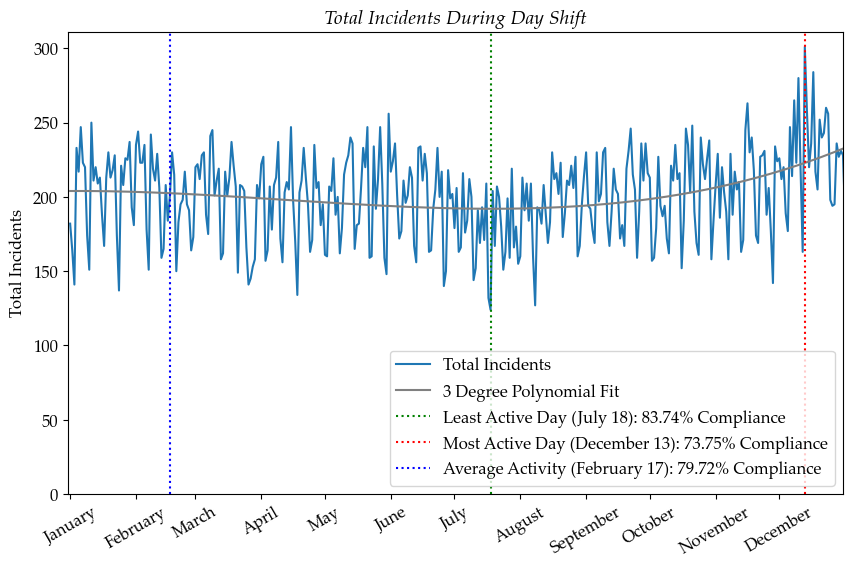

In [11]:
plot_total_incidents_per_day(dataframe, urban=None)


In [12]:
analyze_response_by_date(dataframe, specific_date="01-30")


,urban_settlement_ssb,triage_impression_during_call,mean,median,compliance_rate
0,False,A,15.30,14.58,97.14%
1,False,H,27.63,24.42,83.87%
2,False,V1,44.39,39.72,N/A
3,True,A,10.47,9.50,69.15%
4,True,H,21.37,17.73,83.77%
5,True,V1,65.25,57.70,N/A
